In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from pythainlp.tokenize import word_tokenize
import emoji
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from visualize import top_feats_all, plot_top_feats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('sentiment_analysis.csv')
df = df.drop(df.columns[0], axis=1)
df

,comments,target
0,ดีค่ะ วิทยากรมีความรู้ดีมาก พูดเข้าใจ การสอนมี...,pos
1,ชอบมาก เหมาะสมหรับผู้ที่มีผู้ฐานเรื่องการตลาด ...,pos
2,คอร์สเนื้อหาแน่น และผู้สอนก็สอนได้ละเอียด มีขั...,pos
3,คอร์สนี้ช่วยให้หลักการและกรอบในการดำเนินงานด้า...,pos
4,สอนแบบมี Logic และ วิธีการที่ชัดเจน ชอบมากค่ะ,pos
...,...,...
884,เหมาะสมกับทั้งคนที่ยังไม่มีพื้นฐาน และคนที่อยา...,pos
885,อันนี้รีวิว หลังจากดูจบแล้วครับ\nเกรินก่อน ผมเ...,pos
886,อ.บอย สอนได้ละเอียดมากครับ\nแต่ถ้าเอาไปเขียนเอ...,pos
887,สอนได้ละเอียดกระชับและชัดเจน เข้าใจได้ง่ายครับ...,pos


In [4]:
df.target.value_counts()

pos    789
neg    100
Name: target, dtype: int64

In [5]:
df.isna().sum()

comments    0
target      0
dtype: int64

In [6]:
df = df.dropna()

ลบ URL, เปลี่ยนเป็นตัวพิมพ์เล็ก, ตัดคำอิงจาก(newmm – Dictionary-based), แบ่งกลุ่มพวกemoji

In [7]:
toks = ['😂','🤣😇😚']
def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

ungroup_emoji(toks)

['😂', '🤣', '😇', '😚']

In [8]:
stopwords = ['ที่','และ','เป็น','มี','ให้','ครับ','ค่ะ','ใน','ได้','การ','มา','ๆ','นี้','ไป','จะ']

In [9]:
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    res = text.lower().strip() 
    res = replace_url(text)
    res = [word for word in word_tokenize(text) if word not in stopwords and not re.search(pattern=r"\s+", string=word)]
    res = ungroup_emoji(res)
    return res

In [10]:
df.dtypes

comments    object
target      object
dtype: object

In [11]:
df['processed'] = df.comments.map(lambda x: '|'.join(process_text(x)))
df[df['target']=='pos']

,comments,target,processed
0,ดีค่ะ วิทยากรมีความรู้ดีมาก พูดเข้าใจ การสอนมี...,pos,ดี|วิทยากร|มีความรู้|ดีมาก|พูด|เข้าใจ|การสอน|แ...
1,ชอบมาก เหมาะสมหรับผู้ที่มีผู้ฐานเรื่องการตลาด ...,pos,ชอบ|มาก|เหมาะสม|หรับ|ผู้|ผู้|ฐาน|เรื่อง|การตลา...
2,คอร์สเนื้อหาแน่น และผู้สอนก็สอนได้ละเอียด มีขั...,pos,คอร์ส|เนื้อหา|แน่น|ผู้สอน|ก็|สอน|ละเอียด|ขั้นต...
3,คอร์สนี้ช่วยให้หลักการและกรอบในการดำเนินงานด้า...,pos,คอร์ส|ช่วย|หลักการ|กรอบ|ดำเนินงาน|ด้าน|GTM|ค่อ...
4,สอนแบบมี Logic และ วิธีการที่ชัดเจน ชอบมากค่ะ,pos,สอน|แบบ|Logic|วิธีการ|ชัดเจน|ชอบ|มาก
...,...,...,...
884,เหมาะสมกับทั้งคนที่ยังไม่มีพื้นฐาน และคนที่อยา...,pos,เหมาะสม|กับ|ทั้งคน|ยัง|ไม่|พื้นฐาน|คน|อยาก|ทบท...
885,อันนี้รีวิว หลังจากดูจบแล้วครับ\nเกรินก่อน ผมเ...,pos,อันนี้|รีวิว|หลังจาก|ดู|จบ|แล้ว|เกริน|ก่อน|ผม|...
886,อ.บอย สอนได้ละเอียดมากครับ\nแต่ถ้าเอาไปเขียนเอ...,pos,อ.|บอย|สอน|ละเอียด|มาก|แต่|ถ้า|เอา|เขียน|เอง|ค...
887,สอนได้ละเอียดกระชับและชัดเจน เข้าใจได้ง่ายครับ...,pos,สอน|ละเอียด|กระชับ|ชัดเจน|เข้าใจ|ง่าย|เนื้อหา|...


In [12]:
df[df['target']=='neg']

,comments,target,processed
7,ยังรู้สึกไม่ตรงตามความต้องการ เนื้อหาไม่ละเอียด,neg,ยัง|รู้สึก|ไม่|ตรง|ตาม|ความต้องการ|เนื้อ|หาไม่...
10,อาจารย์สอนเข้าใจดี ขาดเทคนิดในการสอนให้น่าติดต...,neg,อาจารย์|สอน|เข้า|ใจดี|ขาด|เทค|นิด|การสอน|น่า|ต...
16,ได้ภาพกว้างดีค่ะ แต่อยากทำ assignment เยอะหน่อ...,neg,ภาพ|กว้าง|ดี|แต่|อยาก|ทำ|assignment|เยอะ|หน่อย...
20,อ่านมาเล่า,neg,อ่าน|เล่า
22,less explanation in github which quite hard to...,neg,less|explanation|in|github|which|quite|hard|to...
...,...,...,...
837,คลิปสั้นกระชับก็จริงนะคะ แต่เสียตังค์มาแล้วก็อ...,neg,คลิป|สั้น|กระชับ|ก็|จริง|นะคะ|แต่|เสีย|ตังค์|แ...
838,เตรียมขาหมูก่อนทำต้ม​ไม่เป็น​ ในคลิปไม่มีสอนม...,neg,เตรียม|ขา|หมู|ก่อน|ทำ|ต้ม|​|ไม่|​|คลิป|ไม่|สอน...
839,สอนไม่ละเอียดเท่าที่ควร บางอย่างทำเสร็จใส่ถ้วยไว้,neg,สอน|ไม่|ละเอียด|เท่าที่ควร|บางอย่าง|ทำ|เสร็จ|ใ...
846,เรียนแล้วยังไม่ค่อยเข้าใจเท่าไหร่ค่ะ น่าจะเหมา...,neg,เรียน|แล้ว|ยัง|ไม่ค่อย|เข้าใจ|เท่าไหร่|น่าจะ|เ...


/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_8007/1574984743.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pos_word_all = " ".join(text for text in df_pos['processed'].str.replace('|',' '))


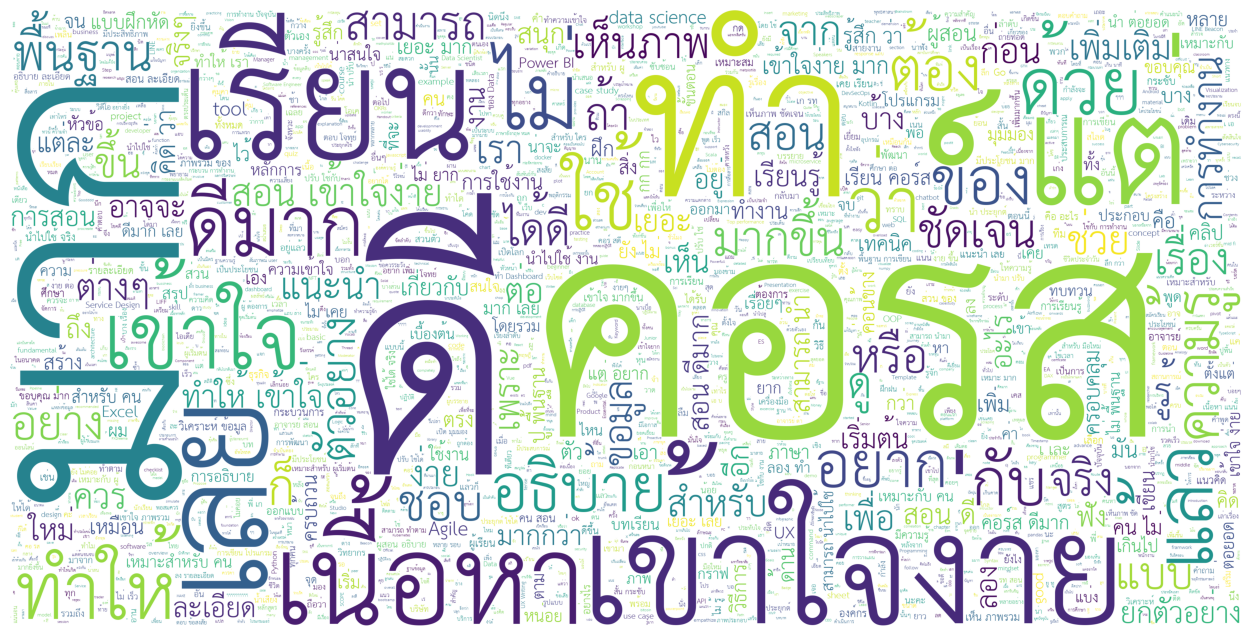

In [13]:
df_pos = df[df['target'] == 'pos']
pos_word_all = " ".join(text for text in df_pos['processed'].str.replace('|',' '))
reg = r"[ก-๙a-zA-Z']+"
fp = 'thsarabunnew-webfont.ttf'
wordcloud = WordCloud(background_color = 'white', max_words=2000, height = 2000, width=4000, font_path=fp, regexp=reg).generate(pos_word_all)
plt.figure(figsize = (16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_8007/1220351340.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  neg_word_all = " ".join(text for text in df_neg['processed'].str.replace('|',' '))


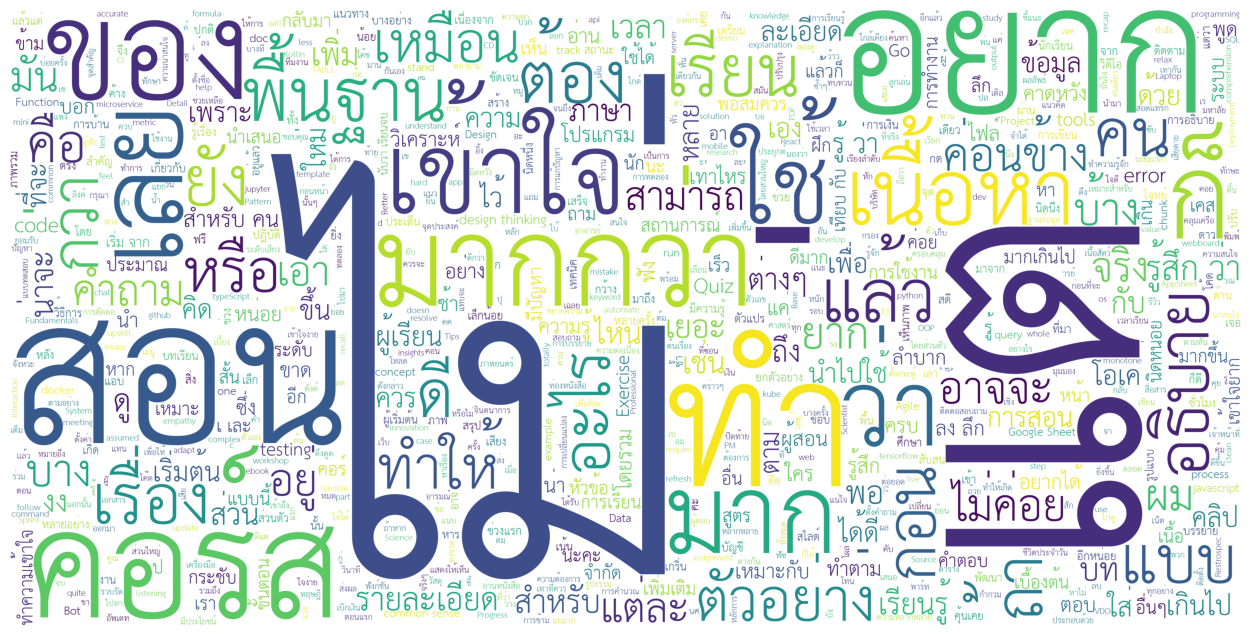

In [14]:
df_neg = df[df['target'] == 'neg']
neg_word_all = " ".join(text for text in df_neg['processed'].str.replace('|',' '))
wordcloud = WordCloud(background_color = 'white', max_words=2000, height = 2000, width=4000, font_path=fp, regexp=reg).generate(neg_word_all)
plt.figure(figsize = (16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('              negative  positive')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)
    
    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

In [ ]:
'''
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1412)
print('train data')
print(train_df.target.value_counts()/train_df.shape[0])
print('test data')
print(test_df.target.value_counts()/test_df.shape[0])
'''

In [ ]:
#(train_df.shape,test_df.shape)

In [ ]:
'''
y_train = train_df['target']
y_test = test_df['target']
'''

คำนวนค่าTF-IDF และทำ Bag of word

In [16]:
#lr = LogisticRegression()

tfidf = TfidfVectorizer(tokenizer=process_text, ngram_range=(1,2), min_df=20, max_df=0.5, sublinear_tf=True)
tfidf_fit = tfidf.fit(df['comments'])
text_df = tfidf_fit.transform(df['comments'])

/Users/suthatipchaithap/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [17]:
features = tfidf_fit.get_feature_names()
ts = top_feats_all(text_df.toarray(), df['target'], features)
print('Positive')
print(ts[1].head(10))
print('Negative')
print(ts[0].head(10))

Positive
   rank     feature     score  ngram label
0     0          ดี  0.067281      1   pos
1     1  เข้าใจง่าย  0.066419      1   pos
2     2         มาก  0.064119      1   pos
3     3       ดีมาก  0.060874      1   pos
4     4         สอน  0.050734      1   pos
5     5       คอร์ส  0.048916      1   pos
6     6      เข้าใจ  0.045493      1   pos
7     7         เลย  0.043169      1   pos
8     8         ไม่  0.039432      1   pos
9     9       เรียน  0.037140      1   pos
Negative
   rank  feature     score  ngram label
0     0      ไม่  0.114686      1   neg
1     1     อยาก  0.078003      1   neg
2     2  มากกว่า  0.073238      1   neg
3     3      สอน  0.065627      1   neg
4     4      แต่  0.061214      1   neg
5     5       ทำ  0.050722      1   neg
6     6      ว่า  0.045841      1   neg
7     7      ของ  0.045644      1   neg
8     8       ก็  0.042638      1   neg
9     9    คอร์ส  0.040695      1   neg


/Users/suthatipchaithap/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
'''
X_train = text_train.toarray()
X_test = text_test.toarray()
X_train.shape, X_test.shape
'''

In [18]:
text = text_df.toarray()

In [ ]:
pd.DataFrame(text, columns=features)

In [19]:
model = LogisticRegression(C=2., penalty='l2', solver='liblinear', dual=False, multi_class='ovr')
#model.fit(X_train,y_train)
#model.score(X_test,y_test)

In [20]:
from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
original_pipeline = Pipeline([
    ('vectorizer', tfidf),
    ('classifier', model)
])
ROS_pipeline = make_pipeline(tfidf, RandomOverSampler(random_state=777),model)

#lr_cv(5, df.comments, df.target, ROS_pipeline, 'macro')

In [21]:
X = df.comments
Y = df.target

In [22]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
accuracy = []
precision = []
recall = []
f1 = []
for train, test in kfold.split(X, Y):
    lr_fit = ROS_pipeline.fit(X[train], Y[train])
    prediction = lr_fit.predict(X[test])
    scores = lr_fit.score(X[test],Y[test])
        
    accuracy.append(scores * 100)
    precision.append(precision_score(Y[test], prediction, average=None)*100)
    print('              negative  positive')
    print('precision:',precision_score(Y[test], prediction, average=None))
    recall.append(recall_score(Y[test], prediction, average=None)*100)
    print('recall:   ',recall_score(Y[test], prediction, average=None))
    f1.append(f1_score(Y[test], prediction, average=None)*100)
    print('f1 score: ',f1_score(Y[test], prediction, average=None))
    print('-'*50)
print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))


              negative  positive
precision: [0.26086957 0.93939394]
recall:    [0.6        0.78481013]
f1 score:  [0.36363636 0.85517241]
--------------------------------------------------
              negative  positive
precision: [0.30555556 0.93661972]
recall:    [0.55       0.84177215]
f1 score:  [0.39285714 0.88666667]
--------------------------------------------------
              negative  positive
precision: [0.38888889 0.95774648]
recall:    [0.7        0.86075949]
f1 score:  [0.5        0.90666667]
--------------------------------------------------
              negative  positive
precision: [0.30555556 0.93661972]
recall:    [0.55       0.84177215]
f1 score:  [0.39285714 0.88666667]
--------------------------------------------------
              negative  positive
precision: [0.27906977 0.94029851]
recall:    [0.6        0.80254777]
f1 score:  [0.38095238 0.86597938]
--------------------------------------------------
accuracy: 80.09% (+/- 2.72%)
precision: 62.51% (+/- 31.

In [ ]:
'''
y_val_pred = model.predict(X_test)
print(classification_report(y_test, y_val_pred))
'''

In [ ]:
'''
conf_mat = confusion_matrix(y_test,y_val_pred)
sns.heatmap(conf_mat, annot=True, fmt="d",xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
'''

In [ ]:
#act_pre = pd.DataFrame({"texts": test_df['processed'], "Actual": y_test, "Predictions": y_val_pred})

In [ ]:
#act_pre.loc[act_pre['Predictions'] == 'neg']

In [ ]:
#act_pre.loc[(act_pre['Predictions'] == 'pos') & (act_pre[ 'Actual'] == 'neg')]

In [ ]:
#act_pre.loc[(act_pre['Predictions'] == 'neg') & (act_pre[ 'Actual'] == 'pos')]

Test

In [23]:
sample = ['สอนดีมากๆค่ะ','อยากให้สอนได้ละเอียดมากกว่านี้','สอนค่อนข้างดี แต่อยากได้ตัวอย่าง','ไม่สนุกเลย','อยากให้เพิ่มเนื้อหา','สอนละเอียดมากครับ']
lr_fit.predict(sample)

array(['pos', 'neg', 'neg', 'neg', 'neg', 'pos'], dtype=object)

In [24]:
import pickle
pickle.dump(lr_fit, open('sentiment_analysis.pkl', 'wb'))